In [1]:
import tensorflow as tf 
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt

In [75]:
image_size=256
batch_size=12
channal=3
epochs=50

In [2]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    shuffle=True,
    image_size=(image_size,image_size),
    batch_size = batch_size
)

Found 2152 files belonging to 3 classes.


In [4]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [5]:
len(dataset)

68

In [7]:
dataset

<_BatchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [10]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch[0])
    print(label_batch[0])

tf.Tensor(
[[[208. 206. 211.]
  [204. 202. 207.]
  [201. 199. 204.]
  ...
  [203. 200. 207.]
  [197. 194. 201.]
  [192. 189. 196.]]

 [[201. 199. 204.]
  [197. 195. 200.]
  [196. 194. 199.]
  ...
  [197. 194. 201.]
  [189. 186. 193.]
  [194. 191. 198.]]

 [[201. 199. 204.]
  [198. 196. 201.]
  [197. 195. 200.]
  ...
  [190. 187. 194.]
  [182. 179. 186.]
  [193. 190. 197.]]

 ...

 [[154. 148. 152.]
  [156. 150. 154.]
  [156. 150. 154.]
  ...
  [149. 148. 154.]
  [140. 139. 145.]
  [145. 144. 150.]]

 [[156. 150. 154.]
  [157. 151. 155.]
  [157. 151. 155.]
  ...
  [144. 143. 149.]
  [143. 142. 148.]
  [142. 141. 147.]]

 [[161. 155. 159.]
  [161. 155. 159.]
  [161. 155. 159.]
  ...
  [136. 135. 141.]
  [143. 142. 148.]
  [138. 137. 143.]]], shape=(256, 256, 3), dtype=float32)
tf.Tensor(0, shape=(), dtype=int32)


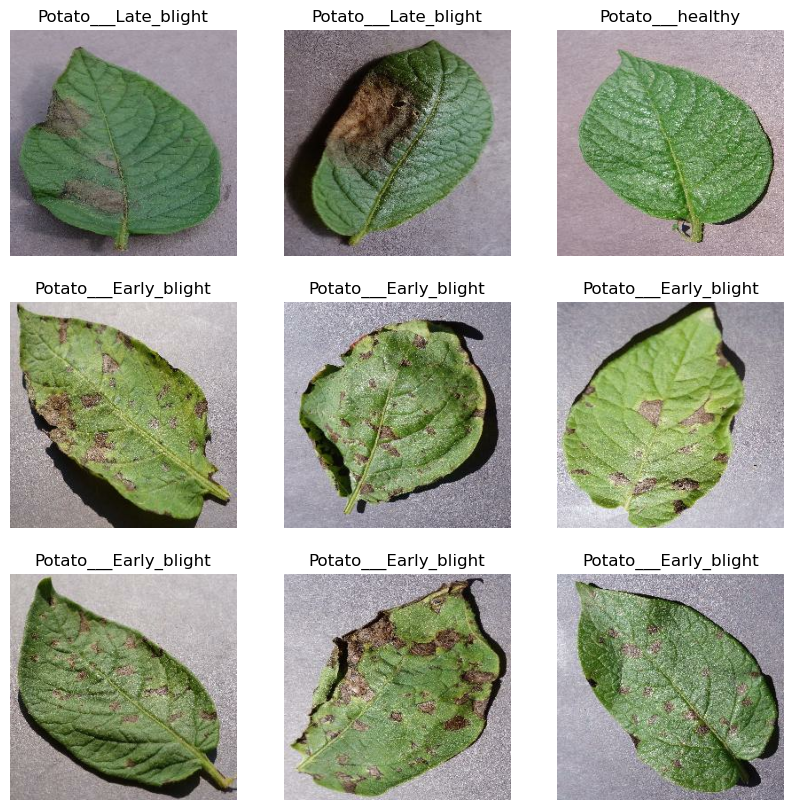

In [25]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [29]:
# 80% ==> training data
# 10% ==> validation
# 10 ==> test

train_size = 0.8
train_size= len(dataset)*train_size 
train_size=int(train_size)

In [30]:
train_ds = dataset.take(train_size)

In [32]:
test_ds =  dataset.skip(train_size)
len(test_ds)

14

In [34]:
val_size = 0.1
val_size = int(len(dataset)*val_size)
val_size

6

In [35]:
val_ds = test_ds.take(val_size)
test_ds = test_ds.skip(val_size)

In [56]:
def get_dataset_split_tf(ds,train_split=0.8,val_split=0.1,test_split=0.1,shuffle=True,shuffle_size=1000):
    ds_size = len(ds)
    
    if shuffle:
        ds= ds.shuffle(shuffle_size,seed= 12)
        
    train_size = int(train_split*ds_size)
    val_size = int(val_split*ds_size)
    
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds,val_ds,test_ds

In [57]:
train_ds, val_ds, test_ds = get_dataset_split_tf(dataset)

In [58]:
len(train_ds)

54

In [59]:
len(test_ds)

8

In [60]:
len(val_ds)

6

In [61]:
train_ds= train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
cal_ds= val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds= test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

In [64]:
resize_and_rescale= tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(256,256),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [67]:
data_augmentation= tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

In [73]:
input_shape = (batch_size,image_size, image_size,channal)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [74]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (256, 256, 256)           0         
                                                                 
 sequential_2 (Sequential)   (256, 256, 256)           0         
                                                                 
 conv2d_18 (Conv2D)          (12, 254, 254, 32)        896       
                                                                 
 max_pooling2d_18 (MaxPoolin  (12, 127, 127, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_19 (Conv2D)          (12, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_19 (MaxPoolin  (12, 62, 62, 64)         0         
 g2D)                                                 

In [76]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [78]:
history = model.fit(
    train_ds,
    batch_size=batch_size,
    validation_data=val_ds,
    verbose=1,
    epochs=1,
)

54/54 [==============================] - 92s 2s/step - loss: 0.7320 - accuracy: 0.6782 - val_loss: 0.5746 - val_accuracy: 0.7031
